In [1]:
import os
import cv2
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Google Drive Connected**
### 1. Directory was splitted into train, test, and validation.
### 2. The output will show how much the train, test, and validation sample was collected and percentage of all ratio.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = os.path.join("/content/drive/My Drive/Data")
!ls "/content/drive/My Drive/Data"

Train_dir = base_dir + '/Train/'
Test_dir = base_dir + '/Test/'
Valid_dir = base_dir + "/Validation/"

nb_train_samples = sum([len(files) for _, _, files in os.walk(Train_dir)])
nb_validation_samples = sum([len(files) for _, _, files in os.walk(Valid_dir)])
nb_test_samples = sum([len(files) for _, _, files in os.walk(Test_dir)])
total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

print(' - # of trained samples: ', nb_train_samples, '\n - # of validation samples: ', nb_validation_samples,
      '\n - # of test samples: ', nb_test_samples,
       '\n - total # of samples: ', total_nb_samples, '\n - train ratio:', round(nb_train_samples/total_nb_samples*100, 2),
      '\n - validation ratio:', round(nb_validation_samples/total_nb_samples*100, 2),
      '\n - test ratio:', round(nb_test_samples/total_nb_samples*100, 2),)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test  Train  Validation
 - # of trained samples:  806 
 - # of validation samples:  181 
 - # of test samples:  163 
 - total # of samples:  1150 
 - train ratio: 70.09 
 - validation ratio: 15.74 
 - test ratio: 14.17


# **Loading Data**
## **Splitting the data is already done in here**

In [0]:
class_names = ['Dumbledore', 'Hagrid', 'Harry', 'Hermione', 'Malfoy', 'Ron']

class_names_label = {class_name : i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMAGE_SIZE = (500, 600)

In [0]:
def load_data():

  datasets = [Train_dir, Valid_dir, Test_dir]
  output = []

  for dataset in datasets:
    Images = []
    Labels = []

    print("Loading {}".format(dataset))

    for folder in os.listdir(dataset):
      curr_label = class_names_label[folder]

      for file in os.listdir(os.path.join(dataset, folder)):
        img_path = os.path.join(os.path.join(dataset, folder), file)

        curr_img = cv2.imread(img_path)
        curr_img = cv2.resize(curr_img, IMAGE_SIZE)

        Images.append(curr_img)
        Labels.append(curr_label)

    Images = np.array(Images)
    Labels = np.array(Labels)
    output.append((Images, Labels))
  return output  

In [5]:
(train_images, train_labels), (valid_images, valid_labels), (test_images, test_labels) = load_data()

Loading /content/drive/My Drive/Data/Train/
Loading /content/drive/My Drive/Data/Validation/
Loading /content/drive/My Drive/Data/Test/


In [6]:
print ("Number of Training Examples: " + str(train_labels.shape[0]))
print ("Number of Validation Examples : " + str(valid_images.shape[0]))
print ("Number of Testing Examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[0:]))

Number of Training Examples: 806
Number of Validation Examples : 181
Number of Testing Examples: 163
Each image is of size: (806, 600, 500, 3)


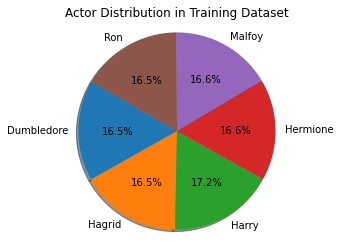

In [7]:
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Actor Distribution in Training Dataset')
plt.show()

# **Data Processing**
## **Step : Normalize the Images**

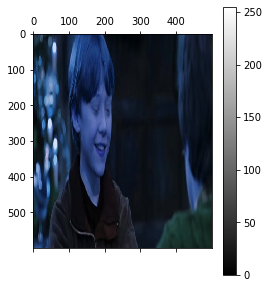

In [8]:
plt.matshow( train_images[0], cmap='gray')
plt.colorbar()
plt.show()

In [9]:
print(train_labels[0])

5


In [0]:
x_train = train_images.reshape((806, 500, 600, 3))
x_valid = valid_images.reshape((181, 500, 600, 3))

train_images = train_images / 255.0 
valid_images = test_images / 255.0

In [11]:
print(train_labels.shape)
print(train_labels[0])

(806,)
5


In [12]:
y_train = tf.keras.utils.to_categorical(train_labels)
y_valid = tf.keras.utils.to_categorical(valid_labels)

print(y_train.shape)
print(y_train[0])

(806, 6)
[0. 0. 0. 0. 0. 1.]


# **Build Simple Convolutional Neural Network**

### Component : Three Convolutional and MaxPool layers.
1. First Layer was 16 filters with 3 by 3
2. Second Layer was Maxpool 2D with pool size of 2 by 2
3. Third Layer was 4 filters with 3 by 3
4. Forth Layer was MaxPool 2D with pool size of 2 by 2
5. Fifth Layer and Sixth Layer was constructed same as step 3 and 4.
6. Fully connected layer was used in Seventh.
7. 128 Neurons with ReLu activation
8. 6 Neurons with Sigmoid activation


In [0]:
x_train[0, :, :, :].shape

(500, 600, 3)

In [0]:
model = Sequential()
model.add( Conv2D(16, (3, 3), activation= 'relu', input_shape = x_train[0, :, :, :].shape))
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation= 'sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 598, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 299, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 297, 4)       580       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 148, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 146, 4)       148       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 73, 4)         0         
_________________________________________

# **Model Compile**

###**Problem : Multiclass, Multilabel.**
1. For the multiclass and multilabel, last-layer activation should be sigmoid rather than softmax, and the loss should be binary_crossentropy rather than categorical_crossentropy.

2. For the optimizer the adam was used, different optimizer can be used in this case such as RMSprop or Adaldelta.

**Some Comments : When I run this with categroical_crossentropy and softmax, the validation accuracy was bounce off within 40 % while training accuracy was going up to 100 %. After chainging the loss and activation function, the validation accuracy was going up to 87%.**



In [0]:
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data= (x_valid, y_valid),
                    epochs=20, 
                    batch_size= 32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 806 samples, validate on 181 samples
Epoch 1/20
806/806 [==============================] - 84s 105ms/sample - loss: 0.9098 - acc: 0.7802 - val_loss: 0.5037 - val_acc: 0.8250
Epoch 2/20
806/806 [==============================] - 83s 103ms/sample - loss: 0.4102 - acc: 0.8563 - val_loss: 0.5120 - val_acc: 0.8508
Epoch 3/20
806/806 [==============================] - 83s 103ms/sample - loss: 0.2381 - acc: 0.9138 - val_loss: 0.5320 - val_acc: 0.8665
Epoch 4/20
806/806 [==============================] - 83s 103ms/sample - loss: 0.1260 - acc: 0.9615 - val_loss: 0.7475 - val_acc: 0.8665
Epoch 5/20
806/806 [==============================] - 83s 103ms/sample - loss: 0.0606 - acc: 0.9835 - val_loss: 0.9386 - val_acc: 0.8748
Epoch 6/20
806/806 [==============================] - 83s 103ms/sample - loss: 0.0389 - acc: 0.9932 - val_loss: 1.0716 - val_acc: 0.8665
Epoch 7/20
806/806 [==================

In [0]:
print(history.params)

{'batch_size': 32, 'epochs': 20, 'steps': None, 'samples': 806, 'verbose': 0, 'do_validation': True, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc']}


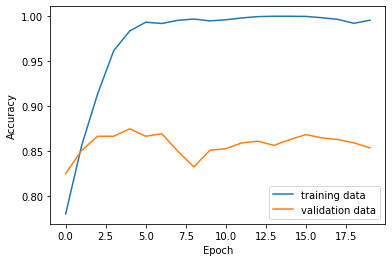

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [0]:
validation_loss, validation_acc = model.evaluate( x_valid, y_valid )
print( 'validation_acc:', validation_acc )

181/181 [==============================] - 6s 32ms/sample - loss: 1.3906 - acc: 0.8536
validation_acc: 0.85359114


In [0]:
predictions = model.predict( x_valid )
print( predictions[0] )

[0.0000000e+00 0.0000000e+00 9.9993038e-01 1.7881393e-07 0.0000000e+00
 0.0000000e+00]


In [0]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
print( predictions[0] )

[0.0000000 0.0000000 0.9999304 0.0000002 0.0000000 0.0000000]


## **Step : Check Recall, Precision, and Accuracy Score**



In [0]:
valid_labels

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4])

In [0]:
np.argmax(predictions, axis=1)

array([2, 5, 2, 3, 0, 0, 3, 3, 3, 4, 4, 3, 0, 3, 3, 4, 2, 3, 3, 3, 5, 1,
       5, 3, 3, 0, 4, 4, 3, 1, 3, 5, 3, 1, 3, 4, 4, 2, 5, 5, 2, 2, 0, 1,
       2, 2, 2, 3, 3, 3, 1, 2, 5, 5, 2, 1, 2, 0, 2, 2, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 4, 0, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 2, 3, 5,
       3, 3, 3, 2, 3, 3, 5, 3, 3, 1, 1, 2, 1, 0, 2, 5, 3, 2, 1, 2, 2, 1,
       2, 2, 5, 1, 1, 1, 1, 0, 2, 1, 1, 1, 5, 3, 1, 0, 2, 5, 4, 3, 4, 4,
       3, 4, 4, 2, 4, 4, 4, 5, 3, 4, 5, 4, 4, 4, 4, 4, 5, 4, 3, 2, 4, 4,
       4, 3, 4, 4, 4])

In [0]:
predictions = np.argmax(predictions, axis=1)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(valid_labels, predictions)
precision = precision_score(valid_labels, predictions, average='micro')
recall = recall_score(valid_labels, predictions, average='micro')
f1_score = f1_score(valid_labels, predictions, average='micro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1_score* 100.0))

Accuracy: 52.49%
Precision: 52.49%
Recall: 52.49%
F1-score: 52.49


#**Phase 2 : Build an Overfitting Model**
1. using all the data(i.e without splitting) obtain close to 100% accuracy. Build as large model as you need(with many filters and many layers)

2. How does the performance(accuracy, precision, recall, etc.) change when the number of filters and layers are increased/decreased

3. If you provide the output as the input (as an additional channel) what is the smallest architecture(minimum number of layers and filters) you need to overfit the data

In [8]:
print(train_images.shape)
print(test_images.shape)
print(valid_images.shape)

(806, 600, 500, 3)
(163, 600, 500, 3)
(181, 600, 500, 3)


In [9]:
all_images = np.concatenate((train_images, valid_images, test_images), axis=0)
print(all_images.shape)
all_labels = np.concatenate((train_labels, valid_labels, test_labels), axis=0)
print(all_labels.shape)

(1150, 600, 500, 3)
(1150,)


## **One-Hot Encoding & Normalization required for all Image Labels**

---



In [0]:
#x_all_train = all_images.reshape((1150, 500, 600, 3))

#print(x_all_train.shape)
x_all_train = all_images / 255.0
y_all_train = tf.keras.utils.to_categorical(all_labels)

In [11]:
print(y_all_train.shape)
print(y_all_train[0])

(1150, 6)
[0. 0. 0. 0. 0. 1.]


# **Building an Overfitting Model**

In [12]:
import keras.backend as K

Using TensorFlow backend.


In [13]:
K.clear_session()

model = Sequential()
model.add( Conv2D(32, (3, 3), activation= 'relu', input_shape = x_all_train[0, :, :, :].shape))
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add( Conv2D(8, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation= 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 498, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 299, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 297, 247, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 123, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 121, 8)       1160      
_________________________________________________________________
flatten (Flatten)            (None, 141328)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [14]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_all_train, y_all_train,
                    epochs=25, 
                    batch_size= 64)

Epoch 1/25
18/18 [==============================] - 4s 248ms/step - loss: 0.8551 - accuracy: 0.2809
Epoch 2/25
18/18 [==============================] - 4s 211ms/step - loss: 0.3583 - accuracy: 0.5174
Epoch 3/25
18/18 [==============================] - 4s 211ms/step - loss: 0.3031 - accuracy: 0.6322
Epoch 4/25
18/18 [==============================] - 4s 211ms/step - loss: 0.1925 - accuracy: 0.8183
Epoch 5/25
18/18 [==============================] - 4s 210ms/step - loss: 0.1278 - accuracy: 0.8843
Epoch 6/25
18/18 [==============================] - 4s 212ms/step - loss: 0.0879 - accuracy: 0.9365
Epoch 7/25
18/18 [==============================] - 4s 213ms/step - loss: 0.0585 - accuracy: 0.9591
Epoch 8/25
18/18 [==============================] - 4s 210ms/step - loss: 0.0331 - accuracy: 0.9791
Epoch 9/25
18/18 [==============================] - 4s 209ms/step - loss: 0.0087 - accuracy: 0.9965
Epoch 10/25
18/18 [==============================] - 4s 210ms/step - loss: 0.0872 - accuracy: 0.9574

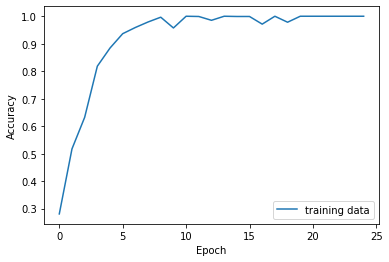

In [17]:
plt.plot(history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'train data_1'], loc='lower right')
plt.show()

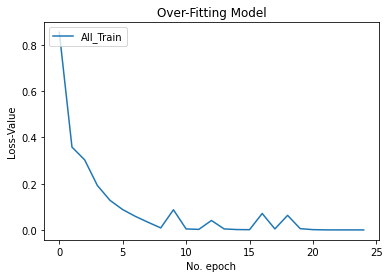

In [18]:
plt.plot(history.history['loss'], label='All_Train')
plt.title('Over-Fitting Model')
plt.ylabel('Loss-Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [0]:
prediction_2 = model.predict(x_all_train)
prediction_2 = np.argmax(prediction_2, axis=1)

In [0]:
prediction_2

array([5, 5, 5, ..., 3, 3, 3])

In [0]:
all_labels

array([5, 5, 5, ..., 3, 3, 3])

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(all_labels, prediction_2)
precision = precision_score(all_labels, prediction_2, average='micro')
recall = recall_score(all_labels, prediction_2, average='micro')
f1_score = f1_score(all_labels, prediction_2, average='micro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1_score* 100.0))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00


# **Observation**
First thing I observed is # of epochs and batch_size

Second thing I observed is # of Layers. Previously,

In [0]:
N = len(x_all_train[:, 0, 0, 0])
L = len(x_all_train[0, :, 0, 0])
W = len(x_all_train[0, 0, :, 0])
xtrain_with_outputlabels = np.zeros((N, L, W, 4))
for i in range(len(x_all_train)):
   existing = x_all_train[i, :, :, :]
   newchannel = np.full((L, W), all_labels[i]).reshape(L, W, 1)
   x = np.concatenate((existing, newchannel), axis = -1)
   xtrain_with_outputlabels[i] = x 

**The print statement was**

**Existing :(500, 600, 3)**

**newchannel :(500, 600, 1)**

**x : (500, 600, 4)**

In [0]:
xtrain_with_outputlabels.shape

(1150, 600, 500, 4)

In [0]:
model = Sequential()
model.add( Conv2D(16, (3, 3), activation= 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape))
model.add(Flatten())
model.add(Dense(6, activation= 'sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 598, 498, 16)      592       
_________________________________________________________________
flatten (Flatten)            (None, 4764864)           0         
_________________________________________________________________
dense (Dense)                (None, 6)                 28589190  
Total params: 28,589,782
Trainable params: 28,589,782
Non-trainable params: 0
_________________________________________________________________


### **I ran this 5 epochs before, then I ran it with epochs=20 again. I was scared if it crashes because I am using most of the ram**

In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(xtrain_with_outputlabels, y_all_train, 
                    epochs=25, 
                    batch_size=64)

Train on 1150 samples
Epoch 1/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 4.6527 - acc: 0.9158
Epoch 2/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.0801 - acc: 0.9755
Epoch 3/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.0529 - acc: 0.9835
Epoch 4/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.2146 - acc: 0.9652
Epoch 5/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.1816 - acc: 0.9616
Epoch 6/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.0682 - acc: 0.9817
Epoch 7/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.2396 - acc: 0.9643
Epoch 8/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.2014 - acc: 0.9528
Epoch 9/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.1676 - acc: 0.9625
Epoch 10/20
1150/1150 [==============================] - 8s 7ms/sample - loss: 0.0983 -

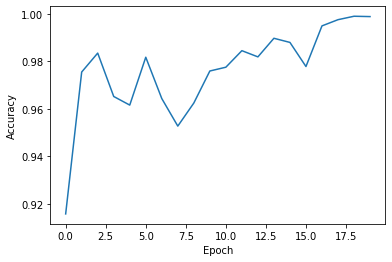

In [0]:
plt.plot(history.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

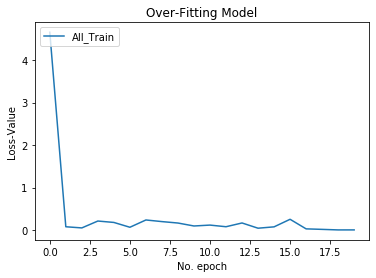

In [0]:
plt.plot(history.history['loss'], label='All_Train')
plt.title('Over-Fitting Model')
plt.ylabel('Loss-Value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [0]:
predictions = model.predict( xtrain_with_outputlabels )

In [0]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})
print( predictions[0] )

[0.0000000 0.0000000 0.0000000 0.0000000 0.0000000 0.9999976]


In [0]:
predictions.shape

(1150, 6)

In [0]:
predictions = np.argmax(predictions, axis=1)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, average='micro')
recall = recall_score(all_labels, predictions, average='micro')
f1_score = f1_score(all_labels, predictions, average='micro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("F1-score: %.2f" % (f1_score* 100.0))

Accuracy: 98.96%
Precision: 98.96%
Recall: 98.96%
F1-score: 98.96
